<a href="https://colab.research.google.com/github/Khaled110/Head_Pose_Estimation/blob/main/Head_Pose_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Head Pose Estimation --> Predicting 3 angles (pitch, yaw and roll) of the head pose using 3 different models from the points on the face that we get from mediapipe package.

### Installing Mediapipe Package

In [438]:
%%capture
!pip install mediapipe

### Importing Needed Libraries

In [439]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import glob
from google.colab.patches import cv2_imshow

# -- for modeling 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# -- ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# -- setting random state for notebook 
np.random.seed(42)

### Downloading Data & Extracting Files

In [440]:
# link to download the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [442]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [443]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    
    """ draw 3 perpendicular axis on the faces in the image

    Parameters:
    ----------
            img --> original image to draw axis on it.
            pitch --> angle to pointing right axis.
            yaw --> angle to pointing down axis.
            roll --> angle to pointing out of screen axis.
            tdx --> center of drawing in the x-axis
            tdy --> center of drawing in the y-axis
            size --> size of the drawn axis 
    
    Returns:
    -------
            img --> image after drawing axis on it.
    """  
    
    yaw = -yaw
    
    # if points not assigned draw from center of the image
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # x-axis pointing right 
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # y-axis pointing down 
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # z-axis out of the screen
    x3 = size*3/4 * (sin(yaw)) + tdx
    y3 = size*3/4 * (-cos(yaw) * sin(pitch)) + tdy

    # --> drawn in red
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),2)
    # --> drawn in green
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),2)
    # --> drawn in blue
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [ ]:
#Extracting Features & Labels

In [444]:
def get_img_points(image_path,isFrame=False):
    """ get points of the faces from a given image using mediapipe,
        then processing and return them.

    Parameters:
    ----------
            image_path --> path to the original image.

    Returns:
    -------
            points --> numpy array of x and y axis for each point from the points on the face in the image,
                      stacking of X_pts and Y_pts after processing

            X_pts --> numpy array of x-axis for each point from the points.
            Y_pts --> numpy array of y-axis for each point from the points.
    """  

    X_pts = []
    Y_pts =[]

    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        if(isFrame):
          image = image_path
        # loading the image
        else:
          image = cv2.imread(image_path)
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          for face in results.multi_face_landmarks:

            X_in_img = []
            Y_in_img = []

            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                X_in_img.append(relative_x)
                Y_in_img.append(relative_y)

            #X_pts.append(np.array(X_in_img))
            #Y_pts.append(np.array(Y_in_img))
            X_pts.append(X_in_img)
            Y_pts.append(Y_in_img)

    X_pts = np.array(X_pts)
    Y_pts = np.array(Y_pts)
    print(X_pts.shape)
    print(Y_pts.shape)

    points = preprocess_pionts(X_pts,Y_pts)
    
    return points , X_pts, Y_pts
              

In [445]:
# defining best max points on the face
left_max_pt = 137
right_max_pt = 352
top_max_pt = 10
bottom_max_pt =171
center_pt = 5

In [446]:
def preprocess_pionts(X_pts,Y_pts):

    """ preprocesses the points of the face.

    Parameters:
    ----------
            X_pts --> numpy array of x-axis for each point from the points.
            Y_pts --> numpy array of y-axis for each point from the points.

    Returns:
    -------
            features --> numpy array of x and y axis for each point from the points on the face in the image,
                      stacking of X_pts and Y_pts after processing (ready for modeling)


    """  

    # centering all points arround a point that in the center of face ( pt -> 5 ) 
    centered_X_pts = X_pts - X_pts[:,center_pt].reshape(-1,1)
    centered_Y_pts = Y_pts - Y_pts[:,center_pt].reshape(-1,1)

    # normalizing points
    X_left_max_pt = X_pts[:, left_max_pt]
    X_right_max_pt = X_pts[:, right_max_pt]
    X_top_max_pt = X_pts[:, top_max_pt] 
    X_bottom_max_pt = X_pts[:, bottom_max_pt] 

    Y_left_max_pt = Y_pts[:, left_max_pt]
    Y_right_max_pt = Y_pts[:, right_max_pt]
    Y_top_max_pt = Y_pts[:, top_max_pt] 
    Y_bottom_max_pt = Y_pts[:, bottom_max_pt] 

    # getting distance between max points of the face.
    h_normed_distance =np.linalg.norm(np.array((X_left_max_pt - X_right_max_pt , Y_left_max_pt - Y_right_max_pt)),axis = 0).reshape(-1,1)
    v_normed_distance =np.linalg.norm(np.array((X_top_max_pt - X_bottom_max_pt , Y_top_max_pt - Y_bottom_max_pt)),axis = 0).reshape(-1,1)


    X_normed = centered_X_pts / v_normed_distance
    #X_normed = X_normed / h_normed_distance
    Y_normed = centered_Y_pts / v_normed_distance 
    #Y_normed = Y_normed / h_normed_distance

    features = np.hstack([X_normed,Y_normed])

    return features

In [447]:
files_names = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")]

def get_labels_and_points(filenames):
    """ get labels and points of the face given the file names of the images and labels in mat files.

    Parameters:
    ----------
            filenames --> list of names of the files.

    Returns:
    -------
            labels --> numpy array of angels labels for each image.
            X_pts --> numpy array of x-axis for each point from the points.
            Y_pts --> numpy array of y-axis for each point from the points.

    """  

    X_pts = []
    Y_pts =[]
    labels=[]

    faceModule = mediapipe.solutions.face_mesh
    for file_name in files_names:
      # loading image and its correspinding mat file
      with faceModule.FaceMesh(static_image_mode=True) as faces:
          # loading the image
          image = cv2.imread('/content/AFLW2000/'+file_name+'.jpg')
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
        
              X_in_img = []
              Y_in_img = []

              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y

                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  X_in_img.append(relative_x)
                  Y_in_img.append(relative_y)

              X_pts.append(np.array(X_in_img))
              Y_pts.append(np.array(Y_in_img))


              mat_file = sio.loadmat('/content/AFLW2000/' + file_name + '.mat')
              
              labels_row = mat_file["Pose_Para"][0][:3]
              labels.append(labels_row)

    labels = np.array(labels)
    X_pts = np.array(X_pts)
    Y_pts = np.array(Y_pts)
    return labels, X_pts ,Y_pts

labels, X_pts ,Y_pts= get_labels_and_points(files_names)

pitch_labels = labels[:,0]
yaw_labels = labels[:,1]
roll_labels = labels[:,2]

In [448]:
# getting features
features = preprocess_pionts(X_pts,Y_pts)
print(X_pts.shape)
print(Y_pts.shape)
print(labels.shape)
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 3)
(1853, 936)


In [449]:
# check for nan values
print(np.count_nonzero(np.isnan(X_pts))," NaNs found.")
print(np.count_nonzero(np.isnan(Y_pts))," NaNs found.")
print(np.count_nonzero(np.isnan(labels))," NaNs found.")
print(np.count_nonzero(np.isnan(features))," NaNs found.")

0  NaNs found.
0  NaNs found.
0  NaNs found.
0  NaNs found.


In [450]:
# Data Splitting
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size = 0.15,random_state = 42)
# y train and test labels for pitch angles
y_train_pitch = y_train[:,0]
y_test_pitch = y_test[:,0]
# y train and test labels for yaw angles
y_train_yaw = y_train[:,1]
y_test_yaw = y_test[:,1]
# y train and test labels for roll angles
y_train_roll = y_train[:,2] 
y_test_roll = y_test[:,2]


In [451]:
def compare_models(models_list,X_train,y_train,X_val,y_val,model_name):

    """ compare between models and print out their performances.

    Parameters:
    ----------
            models_list --> list of models to be compared.
            X_train --> the trained features.
            y_train --> the trained labels.
            X_val --> features to validate on.
            y_val --> labels to validate on.
            model_name --> name of model.

    """  
    for model in models_list:
      model.fit(X_train,y_train)
      print(f"############## {model} ##############")
      print("############## Train Score ##############")
      model_train_pred = model.predict(X_train)
      print(f"{model_name} RMSE : {np.sqrt(mean_squared_error(y_train,model_train_pred))}" )
      print(f"{model_name} MAE : {mean_absolute_error(y_train,model_train_pred)}" )

      print("############## Validation Score ##############")
      model_val_pred = model.predict(X_val)
      print(f"{model_name} RMSE : {np.sqrt(mean_squared_error(y_val,model_val_pred))}" )
      print(f"{model_name} MAE : {mean_absolute_error(y_val,model_val_pred)}")
      print("==============================================")
      print("")

In [452]:
#Gridsearch example for pitch angels using SVR 
'''
parameters = {'kernel':('poly', 'rbf'), 'C':[1,10,25,50,100]}
svr_pitch = SVR(kernel='rbf',C =17)
reg = GridSearchCV(svr_pitch, parameters)
svr_pitch.fit(X_train, y_train_pitch)
print(reg.best_params_)
print(reg.best_estimator_)
'''

"\nparameters = {'kernel':('poly', 'rbf'), 'C':[1,10,25,50,100]}\nsvr_pitch = SVR(kernel='rbf',C =17)\nreg = GridSearchCV(svr_pitch, parameters)\nsvr_pitch.fit(X_train, y_train_pitch)\nprint(reg.best_params_)\nprint(reg.best_estimator_)\n"

In [453]:
# trying different models to predict pitch angle
svr_pitch = SVR(kernel='rbf',C =10)
kn_pitch = KNeighborsRegressor(5)
xgb_pitch = XGBRegressor(n_estimators=10, max_depth=2, learning_rate=0.5)
rf_pitch = RandomForestRegressor(n_estimators=150,max_depth=3, random_state=42)

models = [
          svr_pitch,
         # kn_pitch, 
         # xgb_pitch,
         # rf_pitch
          ]

compare_models(models,X_train,y_train_pitch,X_test,y_test_pitch,"model_pitch")

############## SVR(C=10) ##############
############## Train Score ##############
model_pitch RMSE : 0.527122087907544
model_pitch MAE : 0.09791432148432257
############## Validation Score ##############
model_pitch RMSE : 0.1565594118357785
model_pitch MAE : 0.08737034873196038



In [454]:
# gridsearch example for yaw angels using SVR
'''
parameters = {'kernel':('poly', 'rbf'), 'C':[1,10,25,50,100]}
svr_yaw = SVR()
reg = GridSearchCV(svr_yaw, parameters)
reg.fit(X_train, y_train_yaw)
print(reg.best_params_)
print(reg.best_estimator_)
'''

"\nparameters = {'kernel':('poly', 'rbf'), 'C':[1,10,25,50,100]}\nsvr_yaw = SVR()\nreg = GridSearchCV(svr_yaw, parameters)\nreg.fit(X_train, y_train_yaw)\nprint(reg.best_params_)\nprint(reg.best_estimator_)\n"

In [455]:
# trying different models to predict yaw angle
xgb_yaw = XGBRegressor(n_estimators=25, max_depth=4, learning_rate=0.5)
kn_yaw = KNeighborsRegressor(7)
svr_yaw = SVR(kernel='rbf',C =10)
rf_yaw= RandomForestRegressor(n_estimators=200,max_depth=7)

models = [
         # xgb_yaw,
         # kn_yaw, 
          svr_yaw,
         # rf_yaw
          ]

compare_models(models,X_train,y_train_yaw,X_test,y_test_yaw,"model_yaw")

############## SVR(C=10) ##############
############## Train Score ##############
model_yaw RMSE : 0.20674814661748953
model_yaw MAE : 0.06883238880142073
############## Validation Score ##############
model_yaw RMSE : 0.14294004179788608
model_yaw MAE : 0.07299530830756439



In [456]:
# gridsearch for roll angels using SVR
'''
parameters = {'kernel':('linear', 'rbf'), 'C':[1,10,25,50,100]}
svr_roll = SVR(kernel='poly',C =25)
reg = GridSearchCV(svr_yaw, parameters)
svr_roll.fit(X_train, y_train_yaw)
print(reg.best_params_)
print(reg.best_estimator_)
'''

"\nparameters = {'kernel':('linear', 'rbf'), 'C':[1,10,25,50,100]}\nsvr_roll = SVR(kernel='poly',C =25)\nreg = GridSearchCV(svr_yaw, parameters)\nsvr_roll.fit(X_train, y_train_yaw)\nprint(reg.best_params_)\nprint(reg.best_estimator_)\n"

In [457]:
# trying different models to predict roll angle
xgb_roll = XGBRegressor(n_estimators=25, max_depth=4, learning_rate=0.2)
kn_roll = KNeighborsRegressor(4)
svr_roll = SVR(kernel='rbf',C =10)
rf_roll = RandomForestRegressor(n_estimators=110,max_depth=6)

models = [
         # xgb_roll,
         # kn_roll, 
          svr_roll,
         # rf_roll
          ]

compare_models(models,X_train,y_train_roll,X_test,y_test_roll,"model_roll")

############## SVR(C=10) ##############
############## Train Score ##############
model_roll RMSE : 0.5682079500484418
model_roll MAE : 0.0769897006785417
############## Validation Score ##############
model_roll RMSE : 0.14406222016714523
model_roll MAE : 0.05928613022116822



### Most of models act well on the data, but SVR model is the best in all angles. 




### Final Modeleling

In [458]:
# Modeling
# after gridsearch , comparing models and get best of them, then there is no need to split our data anymore ...

# best model to predict pitch angle
model_pitch = SVR(kernel='rbf',C =10)
model_pitch.fit(features,pitch_labels)

# model prediction and performances
pitch_pred = model_pitch.predict(features)
print(f"model_pitch RMSE : {np.sqrt(mean_squared_error(pitch_labels,pitch_pred))}" )
print(f"model_pitch MAE : {mean_absolute_error(pitch_labels,pitch_pred)}")
print("==============================")
print("")

# best model to predict pitch angle
model_yaw = SVR(kernel='rbf',C =10)
model_yaw.fit(features,yaw_labels)

# model prediction and performances
yaw_pred = model_yaw.predict(features)
print(f"model_yaw RMSE : {np.sqrt(mean_squared_error(yaw_labels,yaw_pred))}" )
print(f"model_yaw MAE : {mean_absolute_error(yaw_labels,yaw_pred)}")
print("==============================")
print("")

# best model to predict pitch angle
model_roll = SVR(kernel='rbf',C =10)
model_roll.fit(features,roll_labels)

# model prediction and performances
roll_pred = model_roll.predict(features)
print(f"model_roll RMSE : {np.sqrt(mean_squared_error(roll_labels,roll_pred))}" )
print(f"model_roll MAE : {mean_absolute_error(roll_labels,roll_pred)}")

model_pitch RMSE : 0.4875773800317196
model_pitch MAE : 0.09436501409366947

model_yaw RMSE : 0.19865662883247995
model_yaw MAE : 0.0677858562161892

model_roll RMSE : 0.528458780620693
model_roll MAE : 0.07266104318340444


### Draw points of a random image

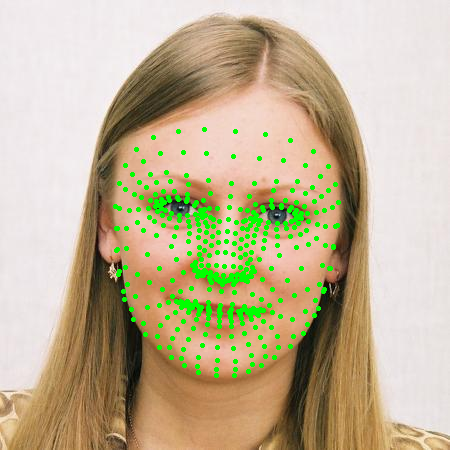

In [459]:
# choosing random image
random_file = 'image00065'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
        
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              
              #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.19, (255, 0, 0), 1)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    cv2_imshow(image)
    

# Predicted angles

(1, 468)
(1, 468)
True : pitch -> -0.13803048431873322 ,yaw -> 0.0023173904046416283 ,roll -> 0.09060649573802948


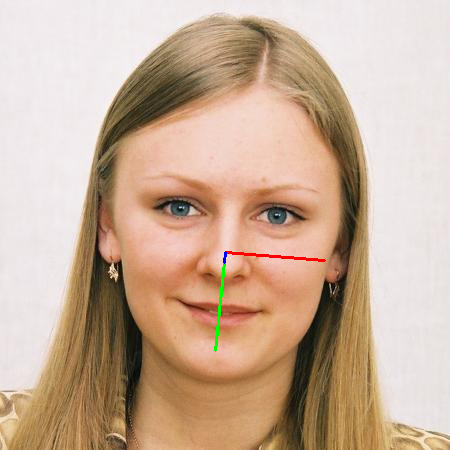


############################################################

Predicted : pitch -> [-0.13596566] ,yaw -> [-0.00977904] ,roll -> [0.07264313]


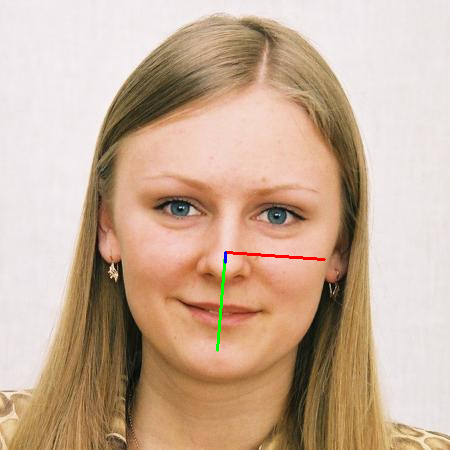

In [463]:
random_file = 'image00065'
img_path = '/content/AFLW2000/'+random_file+'.jpg'
image = cv2.imread(img_path)
# loading the mat file to extract angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting thetrue labels angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]

# get image points

img_points , X_ptd, Y_ptd = get_img_points(img_path)
tdx = X_ptd[:,center_pt]
tdy =Y_ptd[:,center_pt]

# Predicting the labels 3 angels

pitch_pred = svr_pitch.predict(img_points)
yaw_pred = svr_yaw.predict(img_points)
roll_pred = svr_roll.predict(img_points)

print(f"True : pitch -> {pitch} ,yaw -> {yaw} ,roll -> {roll}")
cv2_imshow(draw_axis(image, pitch, yaw, roll,tdx,tdy))


print("\n############################################################\n")

print(f"Predicted : pitch -> {pitch_pred} ,yaw -> {yaw_pred} ,roll -> {roll_pred}")
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
cv2_imshow(draw_axis(image, pitch_pred, yaw_pred, roll_pred,tdx,tdy))



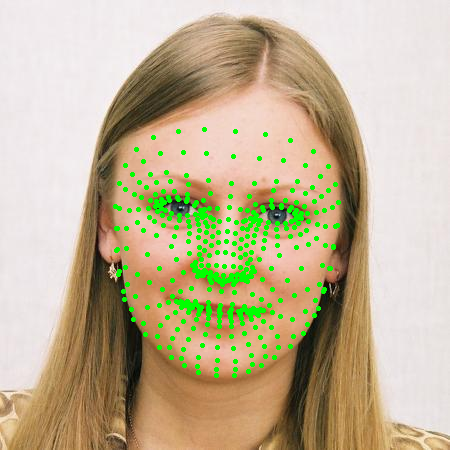


 ============== Best max points on the face ============== 



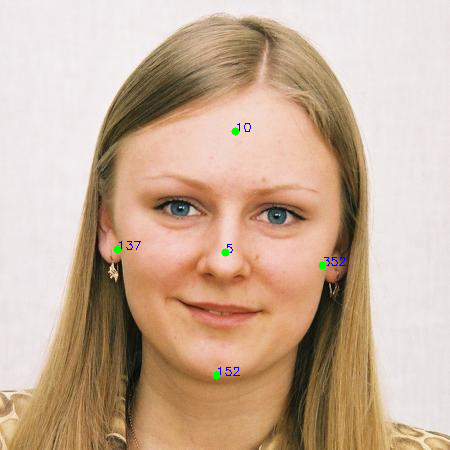

(2, 468)


In [465]:
# choosing random image
random_file = 'image00065'

all_points = []
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    #image = cv2.imread(image_path)
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          Xps = []
          Yps = []
          i = 0
          for landmark in face.landmark:

              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # appending points in its lists
              Xps.append(relative_x)
              Yps.append(relative_y)
              #cv2.putText(image, str(i), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.19, (255, 0, 0), 1)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              i+=1
      all_ps = np.array((Xps,Yps))   

      cv2_imshow(image)
      #range(0,468)
      img = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')  
      # selcting best max points on the face
      print("\n ============== Best max points on the face ============== \n")
      for i in [10,152,5,152,137,352]:  
          ptx=all_ps[0,i]
          pty=all_ps[1,i]
          cv2.putText(img, str(i), (int(ptx),int(pty)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
          cv2.circle(img, (ptx, pty), radius=1, color=(0, 255, 0), thickness=5)
      cv2_imshow(img)
      #print(all_ps.shape)

### Testing On Our Video

In [477]:
def draw_on_video(model_pitch, model_yaw, model_roll,root_path, size = 100, output_name=None):
    """ divide video into frames then draw axes on each frame and finally
        connecting them together and output the video with drawn axes.

    Parameters:
    ----------
            model_pitch --> model that will predict the pitch angles.
            model_yaw --> model that will predict the pitch angles.
            model_roll --> model that will predict the pitch angles.
            size --> size of the drawn axes.

    """  

    vid_cap = cv2.VideoCapture(root_path)
    width= int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height= int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # check if video is openned successfully
    if (vid_cap.isOpened()== False): 
        print("error while opening your video")

    # list to store all video frames in
    Frames_list= []

    while(vid_cap.isOpened()): 
        ret, frame = vid_cap.read()
        if ret == True:
          with faceModule.FaceMesh(static_image_mode=True) as face:
            # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
            results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
              for face in results.multi_face_landmarks:
                  # initializing X and Y lists to store the spacial coordinates of the points
                  X = []
                  Y = []
                  # looping over the landmarks to extract x and y
                  for landmark in face.landmark:
                      x = landmark.x
                      y = landmark.y
                      # retrieve the true values of x and y
                      shape = frame.shape 
                      relative_x = int(x * shape[1])
                      relative_y = int(y * shape[0])
                      X.append(relative_x)
                      Y.append(relative_y)

                  X = np.array(X)
                  Y = np.array(Y)
                  #print(X.shape)
                  #print(Y.shape)

                  # centering the data arround the point
                  points = preprocess_pionts(X.reshape(1,-1),Y.reshape(1,-1))
                  
                  pred_pitch = svr_pitch.predict(points)
                  pred_yaw = svr_yaw.predict(points)
                  pred_roll = svr_roll.predict(points)

                  draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[center_pt],Y[center_pt],size=size)
                  #smothing
                  smothed_frame = cv2.GaussianBlur(frame,(5,5),cv2.BORDER_DEFAULT)
                  Frames_list.append(smothed_frame)
    
        else: 
            break
    vid_cap.release()  
    cv2.destroyAllWindows()
    print(len(Frames_list)," frames found in the video.")
    
    if(output_name!=None):
        video_name = output_name

    else:
        video_name = "output_video"

    output_path = "/content/gdrive/MyDrive/Head_Pose_Estimation/Output_vid/"
    output = cv2.VideoWriter(output_path+ video_name +'_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
    for i in range(len(Frames_list)):
      output.write(Frames_list[i])
    output.release()


In [478]:
from google.colab import drive
# get path of the video on drive
drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/Head_Pose_Estimation/Input_vid/fv.mp4'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [479]:
# call our function to get our test video
draw_on_video(model_pitch,model_yaw,model_roll,root_path,size = 250,output_name="My_Test_Video")

228  frames found in the video.


In [474]:
from google.colab import files
# download our video to our device
files.download('/content/My_Test_Video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>